# Imports

In [2]:
import importlib
import json
import math
from itertools import islice
from pathlib import Path
from typing import Any, Callable

import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from jaxtyping import Float, Int
from matplotlib.axes._axes import Axes
from matplotlib.transforms import Bbox
from n2g import FeatureModel, NeuronStats
from pandas import DataFrame
from torch import Tensor
from transformer_lens import HookedTransformer

import thesis

importlib.reload(thesis)
from thesis.device import Device
from thesis.mas import WeightedSamplesStore, html

/home/user/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Methods

In [3]:
def sorted(x):
    sorted_x = x.copy()
    sorted_x.sort()
    return sorted_x


def bootstrap_metric_std(
    x: np.ndarray, metric: Callable[[np.ndarray], np.ndarray], num_samples: int
) -> tuple[float, float]:
    samples = np.random.choice(x, (num_samples, x.size), replace=True)
    means = metric(samples)
    std = means.std()
    return metric(x).item(), std


def bootstrap_mean_std(x: np.ndarray, num_samples: int) -> tuple[float, float]:
    return bootstrap_metric_std(x, lambda x: x.mean(axis=-1), num_samples)


def bootstrap_min_std(x: np.ndarray, num_samples: int) -> tuple[float, float]:
    return bootstrap_metric_std(x, lambda x: x.min(axis=-1), num_samples)


def bootstrap_test(x: np.ndarray, y: np.ndarray, num_samples: int) -> float:
    """
    Perform a two-sample bootstrap test for the difference of means.
    """
    x_mean = x.mean()
    y_mean = y.mean()
    t = (x_mean - y_mean) / math.sqrt(x.var() / x.size + y.var() / y.size)
    z = (x.sum() + y.sum()) / (x.size + y.size)
    x_prime = x - x_mean + z
    y_prime = y - y_mean + z
    samples_x = np.random.choice(x_prime, (num_samples, x.size), replace=True)
    samples_y = np.random.choice(y_prime, (num_samples, y.size), replace=True)
    x_means = samples_x.mean(axis=1)
    y_means = samples_y.mean(axis=1)
    x_vars = samples_x.var(axis=1)
    y_vars = samples_y.var(axis=1)
    t_samples = (x_means - y_means) / np.sqrt(x_vars / x.size + y_vars / y.size)
    return (t_samples <= t).mean()

# Data

In [4]:
N_MLP = 2048
N_SAE = 2048 * 8
N_TOTAL = N_MLP + N_SAE
N_BOOTSTRAP = 1000
FIRING_THRESHOLD_BIN = 7  # Should match all bins with activation < 0.5

outputs_path = Path("../outputs")
n2g_dir = outputs_path / "gelu-1l_sae_n2g"
stats_path = n2g_dir / "stats.json"

with stats_path.open("r", encoding="utf-8") as f:
    stats_json = json.load(f)
    stats = [NeuronStats.from_dict(neuron_stats) for neuron_stats in stats_json]

assert len(stats) == N_TOTAL, f"Expected {N_TOTAL} stats, got {len(stats)}"

device = Device.get()

mas_path = Path("../outputs/gelu-1l_sae_store.zip")
mas_store = WeightedSamplesStore.load(mas_path, device)

In [5]:
def get_stats(neuron_stats: list[NeuronStats], get: Callable[[NeuronStats], float]) -> list[float]:
    return [get(neuron) for neuron in neuron_stats]


def stats_df(
    stats: list[NeuronStats], feature_densities: Int[Tensor, "num_features num_activation_bins"], group: str
) -> pd.DataFrame:
    densities = feature_densities.cpu().numpy()
    firing_densities = densities[:, FIRING_THRESHOLD_BIN:].sum(axis=1) / densities.sum(axis=1)

    return pd.DataFrame(
        {
            "accuracy": get_stats(stats, lambda x: x.accuracy),
            "firing_recall": get_stats(stats, lambda x: x.firing.recall),
            "firing_precision": get_stats(stats, lambda x: x.firing.precision),
            "firing_f1": get_stats(stats, lambda x: x.firing.f1_score),
            "firing_count": get_stats(stats, lambda x: x.firing.count),
            "non_firing_recall": get_stats(stats, lambda x: x.non_firing.recall),
            "non_firing_precision": get_stats(stats, lambda x: x.non_firing.precision),
            "non_firing_f1": get_stats(stats, lambda x: x.non_firing.f1_score),
            "non_firing_count": get_stats(stats, lambda x: x.non_firing.count),
            "density": firing_densities,
            "log_density": np.log10(firing_densities),
            "group": [group] * len(stats),
        }
    )


mlp_df = stats_df(stats[:N_MLP], mas_store.feature_densities[:N_MLP], "mlp")
sae_df = stats_df(stats[N_MLP:], mas_store.feature_densities[N_MLP:], "sae")

df = pd.concat([mlp_df, sae_df])

/tmp/ipykernel_29068/874539429.py:23: RuntimeWarning: divide by zero encountered in log10
  "log_density": np.log10(firing_densities),


In [6]:
mlp_firing_recall = mlp_df["firing_recall"].to_numpy()
sae_firing_recall = sae_df["firing_recall"].to_numpy()

mlp_firing_precision = mlp_df["firing_precision"].to_numpy()
sae_firing_precision = sae_df["firing_precision"].to_numpy()

mlp_firing_f1_score = mlp_df["firing_f1"].to_numpy()
sae_firing_f1_score = sae_df["firing_f1"].to_numpy()

# NaN and means

In [7]:
mlp_nan_ratio = mlp_firing_f1_score[np.isnan(mlp_firing_f1_score)].size / mlp_firing_f1_score.size
sae_nan_ratio = sae_firing_f1_score[np.isnan(sae_firing_f1_score)].size / sae_firing_f1_score.size

mlp_firing_recall_mean = mlp_firing_recall.mean()
sae_firing_recall_mean = sae_firing_recall.mean()

mlp_firing_precision_mean = mlp_firing_precision[~np.isnan(mlp_firing_precision)].mean()
sae_firing_precision_mean = sae_firing_precision[~np.isnan(sae_firing_precision)].mean()

mlp_firing_f1_score_mean = mlp_firing_f1_score[~np.isnan(mlp_firing_f1_score)].mean()
sae_firing_f1_score_mean = sae_firing_f1_score[~np.isnan(sae_firing_f1_score)].mean()

print(f"MLP nan ratio: {mlp_nan_ratio}")
print(f"SAE nan ratio: {sae_nan_ratio}")
print()
print(f"MLP firing recall mean: {mlp_firing_recall_mean}")
print(f"SAE firing recall mean: {sae_firing_recall_mean}")
print()
print(f"MLP firing precision mean: {mlp_firing_precision_mean}")
print(f"SAE firing precision mean: {sae_firing_precision_mean}")
print()
print(f"MLP firing F1 score mean: {mlp_firing_f1_score_mean}")
print(f"SAE firing F1 score mean: {sae_firing_f1_score_mean}")

MLP nan ratio: 0.02099609375
SAE nan ratio: 0.0262451171875

MLP firing recall mean: 0.23196985756244434
SAE firing recall mean: 0.3603960715886034

MLP firing precision mean: 0.10864152544046578
SAE firing precision mean: 0.2511742334700775

MLP firing F1 score mean: 0.11152450756423117
SAE firing F1 score mean: 0.2556508109037088


# Plots

In [8]:
figure_path = Path("../report/images/figures")
assert figure_path.exists()

In [9]:
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels()
    #    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

In [10]:
counts = {"mlp": N_MLP, "sae": N_SAE}
notnull_counts = {
    "mlp": (1 - mlp_nan_ratio) * N_MLP,
    "sae": (1 - sae_nan_ratio) * N_SAE,
}
notnull_df = df[df["firing_precision"].notnull()]

good_df = notnull_df[notnull_df["firing_f1"].ge(0.5)]

In [25]:
class Plot:
    def __init__(self, plot_func: Callable[[Axes], Any], title: str, xlabel: str, ylabel: str, file_name: str):
        self.plot_func = plot_func
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.file_name = file_name

    def draw(self, ax: Axes) -> None:
        self.plot_func(ax)
        ax.set_title(self.title)
        ax.set_xlabel(self.xlabel)
        ax.set_ylabel(self.ylabel)


def plot_all(
    plots: list[Plot],
    figsize: tuple[float, float],
    save: Path | None = None,
    show: tuple[int, int] | None = None,
    ylim: float | None = None,
) -> None:
    if show:
        figsize = (figsize[0] * show[1], figsize[1] * show[0])
        fig, axes = plt.subplots(show[0], show[1], figsize=figsize)
        for ax, plot in zip(axes.flat, plots, strict=True):
            plot.draw(ax)
            if ylim:
                ax.set_ylim(0, ylim)
        plt.tight_layout()
        plt.show()
    if save:
        for plot in plots:
            fig, ax = plt.subplots(figsize=figsize)
            plot.draw(ax)
            if ylim:
                ax.set_ylim(0, ylim)
            plt.tight_layout()
            fig.savefig(save / f"{plot.file_name}.pdf")
            plt.close(fig)

/tmp/ipykernel_29068/4217762933.py:30: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


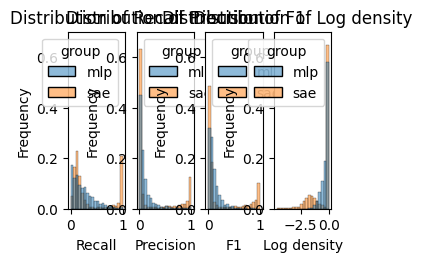

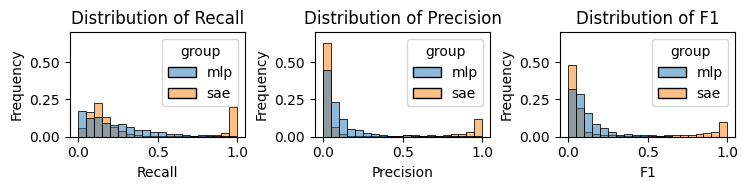

In [27]:
firing_df = notnull_df[notnull_df["density"] > 0]

used_df = firing_df
group_counts = {
    "mlp": used_df[used_df["group"] == "mlp"].shape[0],
    "sae": used_df[used_df["group"] == "sae"].shape[0],
}

plot_info = [
    ("firing_recall", "Recall"),
    ("firing_precision", "Precision"),
    ("firing_f1", "F1"),
    ("log_density", "Log density"),
]
plots = [
    Plot(
        lambda ax, column=column: sns.histplot(
            data=used_df,
            x=column,
            hue="group",
            bins=20,
            weights=1 / used_df["group"].map(group_counts),
            ax=ax,
        ),
        title=f"Distribution of {title}",
        xlabel=title,
        ylabel="Frequency",
        file_name=f"distribution_{title.lower().replace(' ', '_')}",
    )
    for column, title in plot_info
]

plot_all(plots, figsize=(0.85, 2.3), save=figure_path, show=(1, 4), ylim=0.7)


used_df = notnull_df
group_counts = {
    "mlp": used_df[used_df["group"] == "mlp"].shape[0],
    "sae": used_df[used_df["group"] == "sae"].shape[0],
}

plot_info = [
    ("firing_recall", "Recall"),
    ("firing_precision", "Precision"),
    ("firing_f1", "F1"),
]
plots = [
    Plot(
        lambda ax, column=column: sns.histplot(
            data=used_df, x=column, hue="group", bins=20, weights=1 / used_df["group"].map(group_counts), ax=ax
        ),
        title=f"Distribution of {title}",
        xlabel=title,
        ylabel="Frequency",
        file_name=f"distribution_{title.lower().replace(' ', '_')}",
    )
    for column, title in plot_info
]

plot_all(plots, figsize=(2.5, 2), show=(1, 3), ylim=0.7)

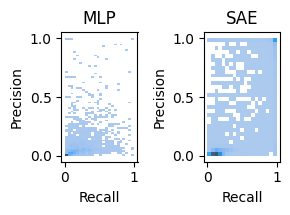

In [13]:
plots = [
    Plot(
        lambda ax: sns.histplot(
            data=notnull_df[notnull_df["group"].eq("mlp")], x="firing_recall", y="firing_precision", ax=ax
        ),
        "MLP",
        "Recall",
        "Precision",
        "recall_precision_mlp",
    ),
    Plot(
        lambda ax: sns.histplot(
            data=notnull_df[notnull_df["group"].eq("sae")], x="firing_recall", y="firing_precision", ax=ax
        ),
        "SAE",
        "Recall",
        "Precision",
        "recall_precision_sae",
    ),
]

plot_all(plots, figsize=(1.5, 2.25), save=figure_path, show=(1, 2))

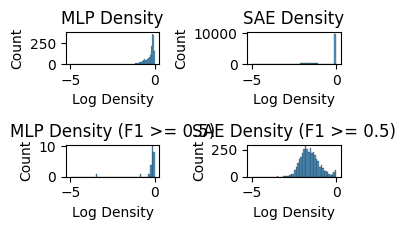

In [14]:
plots = [
    Plot(
        lambda ax: sns.histplot(
            data=notnull_df[notnull_df["group"].eq("mlp")], x="log_density", binrange=(-5, 0), ax=ax
        ),
        "MLP Density",
        "Log Density",
        "Count",
        "density_mlp",
    ),
    Plot(
        lambda ax: sns.histplot(
            data=notnull_df[notnull_df["group"].eq("sae")], x="log_density", binrange=(-5, 0), ax=ax
        ),
        "SAE Density",
        "Log Density",
        "Count",
        "density_sae",
    ),
    Plot(
        lambda ax: sns.histplot(data=good_df[good_df["group"].eq("mlp")], x="log_density", binrange=(-5, 0), ax=ax),
        "MLP Density (F1 >= 0.5)",
        "Log Density",
        "Count",
        "density_mlp_good",
    ),
    Plot(
        lambda ax: sns.histplot(data=good_df[good_df["group"].eq("sae")], x="log_density", binrange=(-5, 0), ax=ax),
        "SAE Density (F1 >= 0.5)",
        "Log Density",
        "Count",
        "density_sae_good",
    ),
]


plot_all(plots, figsize=(1.8, 1.2), save=figure_path, show=(2, 2))

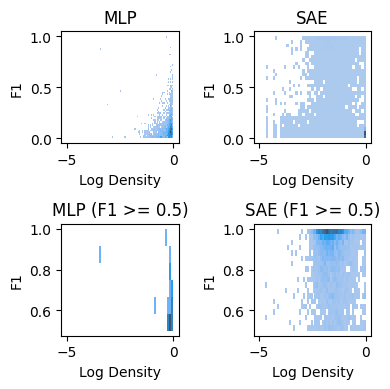

In [15]:
plots = [
    Plot(
        lambda ax: sns.histplot(
            data=notnull_df[notnull_df["group"].eq("mlp")],
            x="log_density",
            y="firing_f1",
            binrange=((-5, 0), (0, 1)),
            ax=ax,
        ),
        "MLP",
        "Log Density",
        "F1",
        "density_f1_mlp",
    ),
    Plot(
        lambda ax: sns.histplot(
            data=notnull_df[notnull_df["group"].eq("sae")],
            x="log_density",
            y="firing_f1",
            binrange=((-5, 0), (0, 1)),
            ax=ax,
        ),
        "SAE",
        "Log Density",
        "F1",
        "density_f1_sae",
    ),
    Plot(
        lambda ax: sns.histplot(
            data=good_df[good_df["group"].eq("mlp")],
            x="log_density",
            y="firing_f1",
            binrange=((-5, 0), (0.5, 1)),
            ax=ax,
        ),
        "MLP (F1 >= 0.5)",
        "Log Density",
        "F1",
        "density_f1_mlp_good",
    ),
    Plot(
        lambda ax: sns.histplot(
            data=good_df[good_df["group"].eq("sae")],
            x="log_density",
            y="firing_f1",
            binrange=((-5, 0), (0.5, 1)),
            ax=ax,
        ),
        "SAE (F1 >= 0.5)",
        "Log Density",
        "F1",
        "density_f1_sae_good",
    ),
]

plot_all(plots, figsize=(2, 2), save=figure_path, show=(2, 2))

# Tests
Only done on roughly the best half of each set of features due to issues with NaN's

In [16]:
def mean_std_test(df: DataFrame, column_name: str, group_x: str, group_y: str, num_bootstrap_samples: int) -> str:
    x_df = df[df["group"].eq(group_x.lower().replace(" ", "_"))]
    y_df = df[df["group"].eq(group_y.lower().replace(" ", "_"))]
    x = x_df[column_name.lower().replace(" ", "_")].to_numpy()
    y = y_df[column_name.lower().replace(" ", "_")].to_numpy()
    assert type(x) == np.ndarray
    assert type(y) == np.ndarray
    assert len(x.shape) == 1

    x_mean, x_mean_std = bootstrap_mean_std(x, num_bootstrap_samples)
    y_mean, y_mean_std = bootstrap_mean_std(y, num_bootstrap_samples)
    x_std = x.std()
    y_std = y.std()
    print(f"{group_x} {column_name} mean: {x_mean:10.3f}   mean std: {x_mean_std:10.3f}  std: {x_std:10.3f}")
    print(f"{group_y} {column_name} mean: {y_mean:10.3f}   mean std: {y_mean_std:10.3f}  std: {y_std:10.3f}")
    recall_stds = abs(x_mean - y_mean) / (x_mean_std + y_mean_std)
    recall_chebychev_p = 1 / (recall_stds**2)
    recall_bootstrap_p = bootstrap_test(x, y, num_bootstrap_samples)
    print(f"stds: {recall_stds:10.2f}    chebychev p: {recall_chebychev_p:10.4f}")
    print(f"p-value: {recall_bootstrap_p:10f}")
    print()
    return f"& {x_mean:10.3f} & {x_std:10.3f} & {y_mean:10.3f} & {y_std:10.3f} \\\\"

In [17]:
notnull_mlp_df = notnull_df[notnull_df["group"].eq("mlp")]
notnull_sae_df = notnull_df[notnull_df["group"].eq("sae")]

recall_row = mean_std_test(
    notnull_df,
    "firing recall",
    "MLP",
    "SAE",
    N_BOOTSTRAP,
)

precision_row = mean_std_test(
    notnull_df,
    "firing precision",
    "MLP",
    "SAE",
    N_BOOTSTRAP,
)

f1_row = mean_std_test(
    notnull_df,
    "firing F1",
    "MLP",
    "SAE",
    N_BOOTSTRAP,
)

density_row = mean_std_test(
    notnull_df,
    "density",
    "MLP",
    "SAE",
    N_BOOTSTRAP,
)

table = (
    "\\begin{tabular}{@{}lllll@{}}\n"
    "\\toprule\n"
    "          & \\multicolumn{2}{l}{MLP} & \\multicolumn{2}{l}{SAE} \\\\ \\cmidrule(l){2-5}\n"
    "          & Mean       & Std        & Mean       & Std        \\\\ \\midrule\n"
    f"Recall    {recall_row}\n"
    f"Precision {precision_row}\n"
    f"F1        {f1_row}\n"
    f"Density   {density_row} \\bottomrule\n"
    "\\end{tabular}\n"
)
print(table)

table_path = figure_path / "distribution_table.tex"
with table_path.open("w", encoding="utf-8") as f:
    f.write(table)

MLP firing recall mean:      0.237   mean std:      0.005  std:      0.203
SAE firing recall mean:      0.367   mean std:      0.003  std:      0.370
stds:      17.40    chebychev p:     0.0033
p-value:   0.000000

MLP firing precision mean:      0.109   mean std:      0.003  std:      0.153
SAE firing precision mean:      0.251   mean std:      0.003  std:      0.373
stds:      22.66    chebychev p:     0.0019
p-value:   0.000000

MLP firing F1 mean:      0.112   mean std:      0.002  std:      0.112
SAE firing F1 mean:      0.256   mean std:      0.003  std:      0.356
stds:      27.07    chebychev p:     0.0014
p-value:   0.000000

MLP density mean:      0.578   mean std:      0.006  std:      0.257
SAE density mean:      0.625   mean std:      0.004  std:      0.459
stds:       5.12    chebychev p:     0.0381
p-value:   0.000000

\begin{tabular}{@{}lllll@{}}
\toprule
          & \multicolumn{2}{l}{MLP} & \multicolumn{2}{l}{SAE} \\ \cmidrule(l){2-5}
          & Mean       & Std     

# Investigation

In [18]:
import torch

device = Device.get()

sae_mas_store = WeightedSamplesStore.load(outputs_path / "gelu-1l_sae_store.zip", device)
print(sae_mas_store.feature_activations()[0].sum())

model: HookedTransformer = HookedTransformer.from_pretrained("gelu-1l", device=device.torch())  # type: ignore[reportUnknownVariableType]
lm = model

all_models_path = n2g_dir / "models" / "all_models.bin"
with all_models_path.open("rb") as f:
    n2g_models_bin = f.read()
    n2g_models = FeatureModel.list_from_bytes(n2g_models_bin)

torch.cuda.empty_cache()

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.12 GiB. GPU 

In [ ]:
# Take all features so indexing is consistent.
mas_samples = sae_mas_store.feature_samples()
mas_activations = sae_mas_store.feature_activations()

nan_features = df.index[df["firing_f1"].isnull() & df["group"].eq("sae")]
perfect_features = df[df["firing_f1"].eq(1) & df["group"].eq("sae")]
perfect_feature_indices = df.index[df["firing_f1"].eq(1) & df["group"].eq("sae")]
print(f"Number of NaN features: {len(nan_features)}/{N_SAE} ({len(nan_features) / N_SAE:.2%})")
print(
    f"Number of perfect features: {len(perfect_feature_indices)}/{N_SAE} ({len(perfect_feature_indices) / N_SAE:.2%})"
)

num_samples = 10

out_path = outputs_path / "bootstrap"
out_path.mkdir(exist_ok=True, parents=True)

nan_dir = out_path / "nan_samples"
nan_dir.mkdir(exist_ok=True, parents=True)
for index in islice(nan_features, num_samples):
    n2g_model = n2g_models[index]

    graph = graphviz.Source.from_file(graph_file)
    html_str = html.generate_html(model, mas_samples[index], mas_activations[index], n2g_source=graph)
    with (nan_dir / f"{index}.html").open("w", encoding="utf-8") as f:
        f.write(html_str)

bad_dir = out_path / "bad_samples"
bad_dir.mkdir(exist_ok=True, parents=True)
bad_indices = df.sort_values("firing_precision").index[df["group"].eq("sae")]
for index in islice(bad_indices, num_samples):
    graph_file = graph_dir / f"{index}.dot"
    graph = graphviz.Source.from_file(graph_file)
    html_str = html.generate_html(model, mas_samples[index], mas_activations[index], n2g_source=graph)
    with (bad_dir / f"{index}.html").open("w", encoding="utf-8") as f:
        f.write(html_str)


perfect_dir = outputs_path / "perfect_samples"
perfect_dir.mkdir(exist_ok=True, parents=True)
for index in islice(perfect_feature_indices, num_samples):
    graph_file = graph_dir / f"{index}.dot"
    graph = graphviz.Source.from_file(graph_file)
    html_str = html.generate_html(model, mas_samples[index], mas_activations[index], n2g_source=graph)
    with (perfect_dir / f"{index}.html").open("w", encoding="utf-8") as f:
        f.write(html_str)

Number of NaN features: 430/16384 (2.62%)
Number of perfect features: 991/16384 (6.05%)


NameError: name 'n2g_models' is not defined

<Axes: xlabel='log_density', ylabel='Count'>

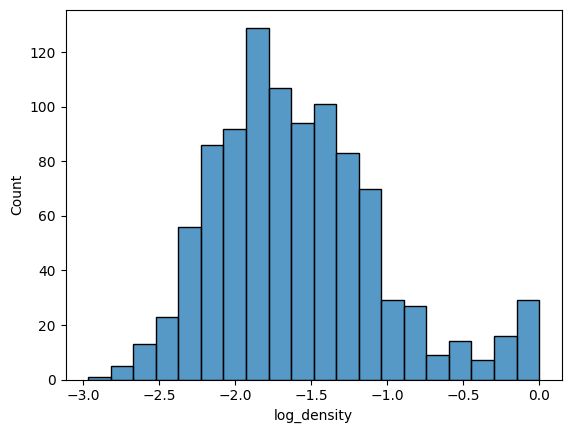

In [ ]:
sns.histplot(data=perfect_features, x="log_density", bins=20)

In [ ]:
import asyncio
import pickle
from typing import Iterable

import aiofiles
import nest_asyncio

nest_asyncio.apply()


models_path = outputs_path / "models"


async def read_model(index: int) -> NeuronModel:
    async with aiofiles.open(models_path / f"{index}.pkl", "rb") as f:
        data = await f.read()
    return pickle.loads(data)


def read_models(indices: Iterable[int]) -> list[NeuronModel]:
    return asyncio.get_event_loop().run_until_complete(asyncio.gather(*[read_model(index) for index in indices]))


perfect_models = read_models(perfect_feature_indices)

In [ ]:
node_count_counts = {}
for feature_model in perfect_models:
    node_count = feature_model.node_count
    if node_count not in node_count_counts:
        node_count_counts[node_count] = 0
    node_count_counts[node_count] += 1
max_node_count = max(node_count_counts.keys())
for node_count in range(1, max_node_count + 1):
    if node_count in node_count_counts:
        print(f"{node_count:03}: {node_count_counts[node_count]}")

003: 193
005: 1
006: 41
007: 2
008: 2
009: 15
010: 2
011: 5
012: 8
013: 1
014: 2
015: 11
017: 1
018: 2
019: 1
020: 3
021: 1
022: 2
023: 2
024: 2
026: 2
027: 6
030: 3
031: 2
033: 6
034: 2
035: 4
036: 5
038: 1
039: 1
040: 1
041: 2
042: 2
044: 2
045: 6
047: 3
048: 3
049: 1
050: 2
051: 1
052: 1
054: 2
056: 1
057: 3
058: 1
059: 2
060: 2
062: 1
063: 1
066: 1
067: 2
068: 1
069: 2
072: 3
073: 1
074: 1
075: 1
076: 2
077: 2
078: 2
080: 1
081: 1
082: 3
086: 1
089: 3
090: 3
092: 1
093: 1
094: 1
096: 1
097: 1
098: 4
100: 3
102: 3
106: 3
107: 1
108: 2
109: 2
110: 1
114: 4
115: 2
116: 1
117: 2
118: 3
119: 3
120: 2
122: 1
123: 1
124: 2
125: 2
126: 1
127: 3
128: 4
129: 1
130: 2
131: 1
132: 3
133: 2
134: 2
136: 1
137: 1
138: 1
140: 2
142: 2
144: 1
145: 1
148: 4
150: 2
153: 1
156: 1
157: 1
158: 3
159: 3
160: 1
161: 1
163: 1
164: 1
165: 1
166: 2
168: 2
171: 1
172: 2
173: 1
174: 1
175: 1
176: 1
177: 1
178: 1
181: 1
184: 1
185: 1
186: 1
187: 2
190: 1
191: 1
196: 1
197: 2
199: 2
200: 2
204: 1
205: 1
210: 1
2

In [ ]:
import torch
from n2g import NeuronStats

index = 4985
model_stats = df.loc[index]
feature_model = await read_model(index)

samples = sae_mas_store.feature_samples()[index]
activations = sae_mas_store.feature_activations()[index]
feature_model_activations = torch.zeros_like(activations)
for sample_index, sample in enumerate(samples):
    sample_strs: list[str] = model.to_str_tokens(sample)
    [features_model_sample_activations] = feature_model.forward([sample_strs])
    feature_model_activations[sample_index] = torch.tensor(features_model_sample_activations)

html_str = html.generate_html(
    model, samples, feature_model_activations, n2g_source=graphviz.Source(feature_model.graphviz().source)
)
with open(f"outputs/models/n2g_activations_{index}.html", "w", encoding="utf-8") as f:
    f.write(html_str)

firings = (activations >= 0.5).ravel()
pred_firings = (feature_model_activations >= 0.5).ravel()
stats = NeuronStats.from_firings(firings.cpu().numpy(), pred_firings.cpu().numpy())

print(stats)
print(f"df stats: {model_stats}")


print(f"{feature_model.root[0].children.keys()}")

accuracy=0.9739990234375 non_firing=ClassStats(precision=0.9738842569887199, recall=1.0, f1_score=0.9867693645568048, count=7943) firing=ClassStats(precision=1.0, recall=0.14457831325301204, f1_score=0.25263157894736843, count=249)
df stats: accuracy                0.936279
firing_recall           0.109091
firing_precision        0.027523
firing_f1               0.043956
firing_count                  55
non_firing_recall       0.947538
non_firing_precision    0.987365
non_firing_f1           0.967041
non_firing_count            4041
group                        sae
Name: 4985, dtype: object
dict_keys(['O', 'M', 'P', 'H', 'C', 'F', 'B', 'N', 'D', 'J', 'T', 'W', 'L', 'A', 'R', 'I', 'V', 'K', 'Y', 'E', 'U', 'S'])
